# Unsupervised VAE analysis & further retraining the last layer

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score


from pretrain_neptune.get_pretrain_encoder import get_pretrain_encoder_from_modelID, get_pretrain_input_data
from pretrain.latent_task_predict import log_reg_multi_class, ridge_regression_predict


%who



2024-10-07 04:15:48.246030: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 04:15:48.264631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 04:15:48.284008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 04:15:48.289776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 04:15:48.305306: I tensorflow/core/platform/cpu_feature_guar

DataLoader	 LabelEncoder	 PCA	 TensorDataset	 accuracy_score	 f1_score	 get_pretrain_encoder_from_modelID	 get_pretrain_input_data	 imaplib	 
importlib	 label_encoder	 log_reg_multi_class	 ml_code_path	 nn	 np	 optim	 optuna	 os	 
pd	 plt	 precision_score	 random	 recall_score	 ridge_regression_predict	 roc_auc_score	 sns	 torch	 
umap	 


## Visulization functions

In [21]:
# Function to filter and plot categorical data

# Convert categorical data (e.g., study IDs) to numeric values
from sklearn.preprocessing import LabelEncoder


def filter_and_plot_cat(Z_reduced, y_data, data_label, task, ax, palette='tab10', method='UMAP'):
    valid_rows = y_data[[task]].dropna().index
    # Convert valid_rows into integer indices that NumPy arrays understand
    valid_indices = [y_data.index.get_loc(idx) for idx in valid_rows]
    Z_filtered = Z_reduced[valid_indices]
    y_filtered = y_data.loc[valid_rows, task]
    y_filtered= label_encoder.fit_transform(y_filtered)
    y_filtered= y_filtered.astype(int)
    y_filtered = pd.Series(y_filtered)

    # Count the number of samples for each category
    category_counts = y_filtered.value_counts().to_dict()

    # Create a custom legend label with sample counts
    custom_legend_labels = [f'{cat}: {count} samples' for cat, count in category_counts.items()]

    # Plot the reduced data with smaller dots and transparency for categorical data
    sns.scatterplot(x=Z_filtered[:, 0], y=Z_filtered[:, 1], hue=y_filtered, palette=palette, s=10, alpha=0.5, ax=ax)

    # Title with the total number of samples
    ax.set_title(f"{data_label} colored by {task} (n={len(valid_rows)})", fontsize=20)
    ax.set_xlabel(f'{method} Component 1', fontsize=18)
    ax.set_ylabel(f'{method} Component 2', fontsize=18)

    # Update the legend with sample counts
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, custom_legend_labels, title=f"{task} (n={len(valid_rows)})", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)



## Evaluating unsupervised models

#### getting the input data

In [3]:
# getting the input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_S_8.1.1'
(X_data_all, y_data_all, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=  get_pretrain_input_data(input_data_location)

X_data_all.shape, y_data_all.shape, X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, X_data_test.shape, y_data_test.shape

/home/leilapirhaji/mz_embed_engine/ml/pretrain_neptune/get_pretrain_encoder.py:72: DtypeWarning: Columns (1,8,28,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  y_data_all = pd.read_csv(pretrain_y_all, index_col=0)
/home/leilapirhaji/mz_embed_engine/ml/pretrain_neptune/get_pretrain_encoder.py:75: DtypeWarning: Columns (1,8,14,15,24,25,26,28,29,30,31,32,33,34,46,50,51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  y_data_train = pd.read_csv(pretrain_y_train, index_col=0)


((20548, 2736),
 (20548, 58),
 (17465, 2736),
 (17465, 58),
 (2055, 2736),
 (2055, 58),
 (1028, 2736),
 (1028, 58))

In [6]:
y_data_test.columns

Index(['Matt Set Label', 'Previous run_order', 'Previous MV', 'Study ID',
       'is Pediatric', 'Cohort Label v0', 'Job ID', 'Cancer Risk', 'Column',
       'Polarity', 'Sex', 'Subject ID', 'Age', 'Diagnosis', 'Region',
       'Smoking Status', 'Sample_Class', 'Ref', 'run_order', 'timestamp',
       'runtime_hour', 'batch_id', 'BMI', 'Race', 'Treatment',
       'Diagnosis Type', 'is Female', 'Type', 'Ethnicity', 'mzml path',
       'Batch', 'SARS-CoV-2 Positive', 'Matt Set', 'Set', 'NIVO OS', 'EVER OS',
       'Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY',
       'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'OS', 'OS_Event',
       'Timepoint', 'Dose (mg/kg)', 'PFS', 'PFS_Event', 'ORR', 'Benefit',
       'Clinical Trial Phase', 'Diagnosis Details', 'Emphysema/COPD', 'IMDC',
       'MSKCC', 'Prior_2', 'Benzene_Exposure_Category'],
      dtype='object')

### loading the pretrain VAE models


In [3]:
import importlib
import pretrain.get_pretrain_encoder
importlib.reload(pretrain.get_pretrain_encoder)
from pretrain.get_pretrain_encoder import get_pretrain_encoder_from_local

pretrain_save_dir='/home/leilapirhaji/pretrained_models'
pretrain_name='pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1'
pretrain_trial_list=[143]
pretrain_id=pretrain_trial_list[0]

(pretrain_vae, Z_train, Z_val, Z_test)=get_pretrain_encoder_from_local(pretrain_name, pretrain_id, pretrain_save_dir)
pretrain_vae

VAE(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=1524, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=1524, out_features=850, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=850, out_features=850, bias=True)
    )
  )
  (decoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=425, out_features=850, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=850, out_features=1524, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=1524, out_features=2736, bias=True)
    )
  )
)

# Re-training the last layer of unsupervised VAE models

## grid search par opt

In [7]:
#!/bin/bash
#!cd /home/leilapirhaji/mz_embed_engine/ml

# Define common variables
INPUT_DATA_LOCATION="/home/leilapirhaji/PROCESSED_DATA_S_8.1.1"
PRETRAIN_SAVE_DIR="/home/leilapirhaji/pretrained_models"
pretrain_model_name="pretrain_VAE_L_400_425_e_400_p_25_s_8.1.1"
pretrain_trial_ID="143"

# TASK='Age'


# !python ./pretrain/retrain_last_layer_pretrain_VAE_main.py \
#     --input_data_location "$INPUT_DATA_LOCATION" \
#     --pretrain_save_dir "$PRETRAIN_SAVE_DIR" \
#     --pretrain_model_name "$pretrain_model_name" \
#     --pretrain_trial_ID "$pretrain_trial_ID" \
#     --task "$TASK" \
#     --add_post_latent_layers 'False' \
#     --post_latent_layer_size "64" \
#     --num_layers_to_retrain "1" \
#     --dropout_rate 0.4 \
#     --learning_rate 1e-5 1e-4 \
#     --l1_reg 1e-6 \
#     --weight_decay 1e-3 \
#     --batch_size 32 \
#     --patience 0 \
#     --num_epochs 20

In [8]:
#open the results of grid search
#reading the output
TASK='Study ID'
task=TASK.replace(' ','_')

result_path=f'{PRETRAIN_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}'

#best paramteres
with open(f'{result_path}/{task}_best_params_grid_search.txt', 'r') as f:
    best_params = f.read()        

#best model results
best_model_results=pd.read_csv(f'{result_path}/{task}_best_model_results.csv')
    
#All grid search results
all_grid_search_results= pd.read_csv(f'{result_path}/{task}_all_grid_search_results.csv')
#all_grid_search_results.sort_values('val_loss', ascending=True, inplace=True)
# Convert a column (e.g., column 'B') to scientific notation
all_grid_search_results['learning_rate'] = all_grid_search_results['learning_rate'].apply(lambda x: '{:.2e}'.format(x))

all_grid_search_results

add_post_latent_layers  post_latent_layer_size  num_layers_to_retrain  \
0                   False                      64                      1   
1                   False                      64                      1   
2                   False                      64                      1   

   dropout learning_rate  l1_reg_weight  l2_reg_weight  batch_size  patience  \
0      0.4      1.00e-04       0.000001          0.001          32         0   
1      0.4      1.00e-04       0.000001          0.001          32         0   
2      0.4      1.00e-04       0.000001          0.001          32         0   

   num_epochs  val_metric  
0           1   69.836813  
1           2    0.002313  
2          20    0.002313

In [9]:
best_model_results

Unnamed: 0        Data  Accuracy  Precision    Recall  F1 Score        AUC
0           0       Train  0.286287   0.000820  0.286287  0.001635  41.682213
1           0  Validation  0.340633   0.001160  0.340633  0.002313  48.828147
2           0        Test  0.291829   0.000852  0.291829  0.001698  47.810680

In [10]:
best_params

"{'add_post_latent_layers': False, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'dropout': 0.4, 'learning_rate': 0.0001, 'l1_reg_weight': 1e-06, 'l2_reg_weight': 0.001, 'batch_size': 32, 'patience': 0, 'num_epochs': 20}"

## Getting the model and the latnet space

In [11]:
task='Study_ID'
result_path=f'{PRETRAIN_SAVE_DIR}/{pretrain_model_name}/trial_{pretrain_trial_ID}/{task}'
model_path=f'{result_path}/{task}_best_model_grid_search'
best_model_file=f'{model_path}/best_model.pth'
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

adv_model=torch.load(best_model_file, map_location=device)

adv_model

FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=1524, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=1524, out_features=850, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=850, out_features=850, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=425, out_features=22, bias=True)
    (1): Softmax(dim=1)
  )
)

In [12]:
from pretrain.eval_pretrained_VAE import generate_latent_space
latent_passes=20

def get_latent(x_data, model, name):
    Z=[]
    for _ in range(latent_passes):  # Generate multiple latent representations   
        # Convert DataFrames to Tensors
        latent_rep_all = torch.tensor(generate_latent_space(x_data, model).values, dtype=torch.float32)
        Z.append(latent_rep_all)

    # Averaging the latent spaces
    Z = torch.mean(torch.stack(Z), dim=0)
    #now converting the latent space to dataframe
    Z = pd.DataFrame(Z, index=x_data.index)
    #save to csv
    Z.to_csv(f'{model_path}/Z_{name}_avg_{latent_passes}.csv')
    
    return Z 


Z_all_adv=get_latent( X_data_all, adv_model, 'all')
Z_train_adv=get_latent (X_data_train, adv_model, 'train')
Z_val_adv=get_latent (X_data_val, adv_model, 'val')
Z_test_adv=get_latent (X_data_test, adv_model, 'test')


# Z_all_sex=pd.read_csv(f'{model_path}/Z_all_avg_{latent_passes}.csv', index_col=0)
# Z_train_sex=pd.read_csv(f'{model_path}/Z_train_avg_{latent_passes}.csv', index_col=0)
# Z_val_sex=pd.read_csv(f'{model_path}/Z_val_avg_{latent_passes}.csv', index_col=0)
# Z_test_sex=pd.read_csv(f'{model_path}/Z_test_avg_{latent_passes}.csv', index_col=0)

Z_all_adv.shape, Z_train_adv.shape, Z_val_adv.shape, Z_test_adv.shape


((20548, 425), (17465, 425), (2055, 425), (1028, 425))

## UMAP

### Train Samples

In [13]:
reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, n_epochs=1000)
#reducer = umap.UMAP(n_components=2)
Z_reduced_train_adv = reducer.fit_transform(Z_train_adv)
Z_reduced_train_adv.shape

(17465, 2)

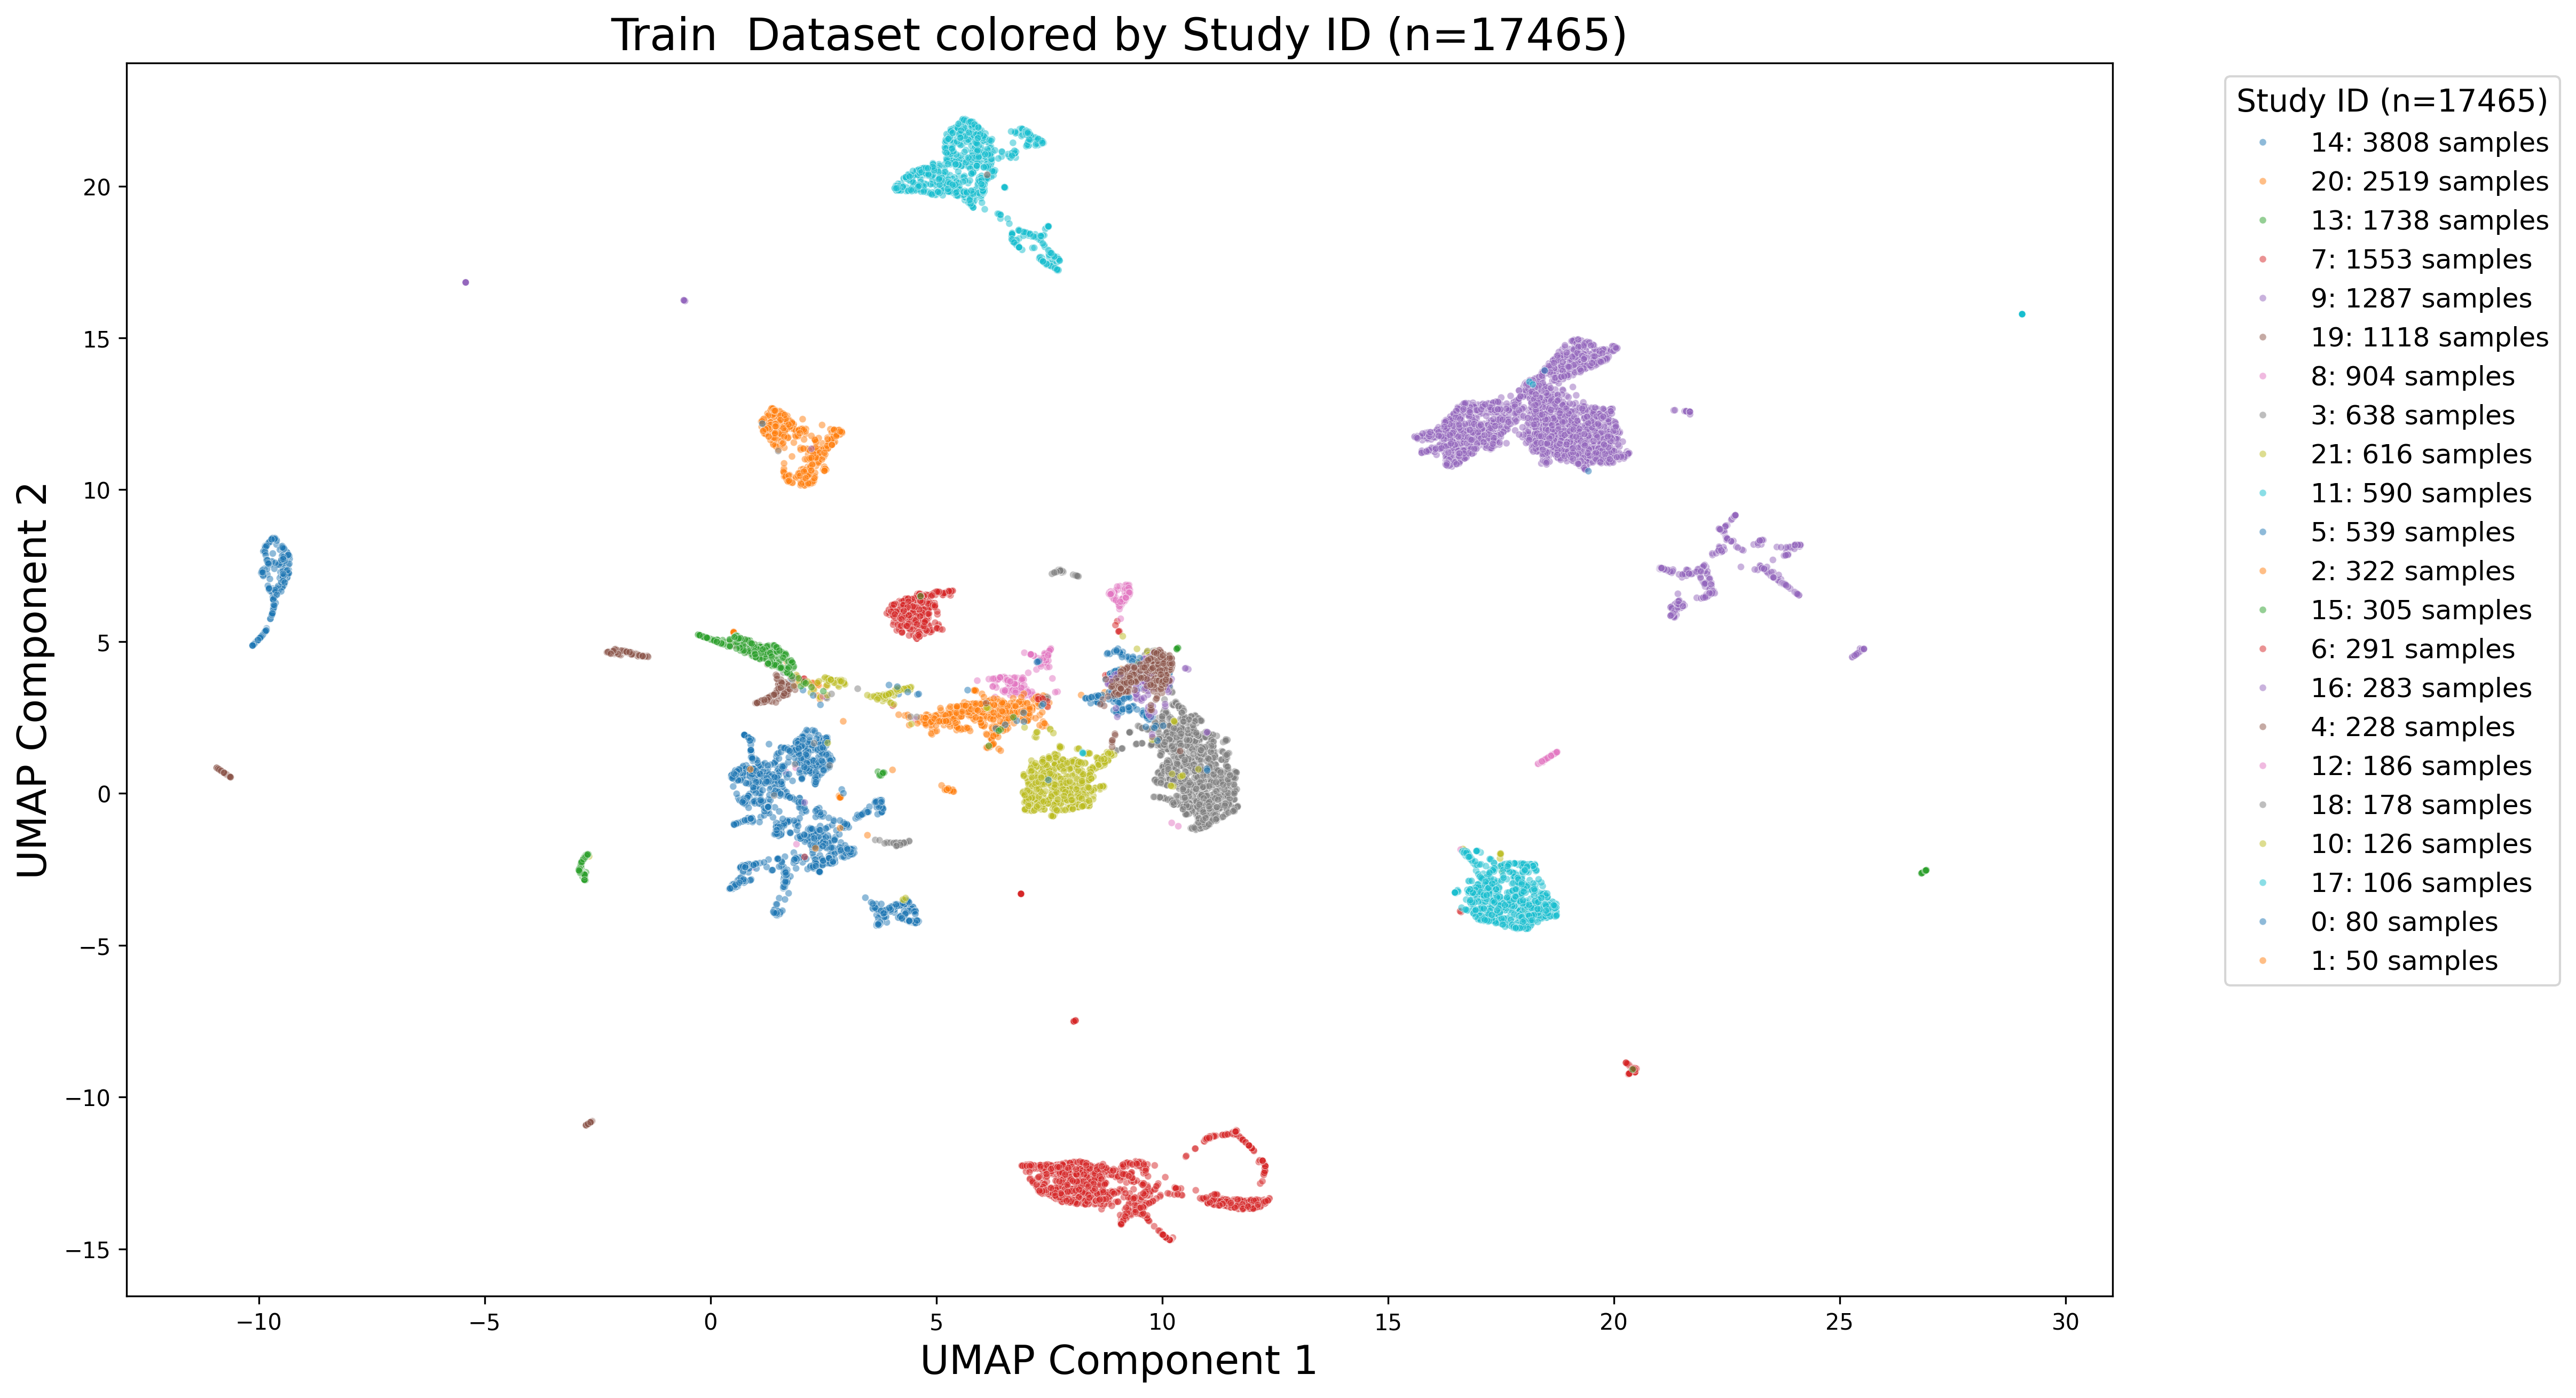

In [25]:
import matplotlib.pyplot as plt
task='Study ID'
fig, axs = plt.subplots(figsize=(16,10), dpi=300)  # Adjusted figsize for square subplots
filter_and_plot_cat(Z_reduced_train_adv, y_data_train, 'Train  Dataset', task, axs)
# axs.set_xlim(10, None)  # y-axis limits, lower bound of -4, no upper bound
# axs.set_ylim(6, None) 

task_name=task.replace(' ','_')
fig.savefig(f'{model_path}/Z_train_avg_{task_name}_UMAP.png')
#plt.tight_layout()

### Val Samples

In [26]:
#reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, n_epochs=1000)
reducer = umap.UMAP(n_components=2)
Z_reduced_val_adv = reducer.fit_transform(Z_val_adv)
Z_reduced_val_adv.shape

(2055, 2)

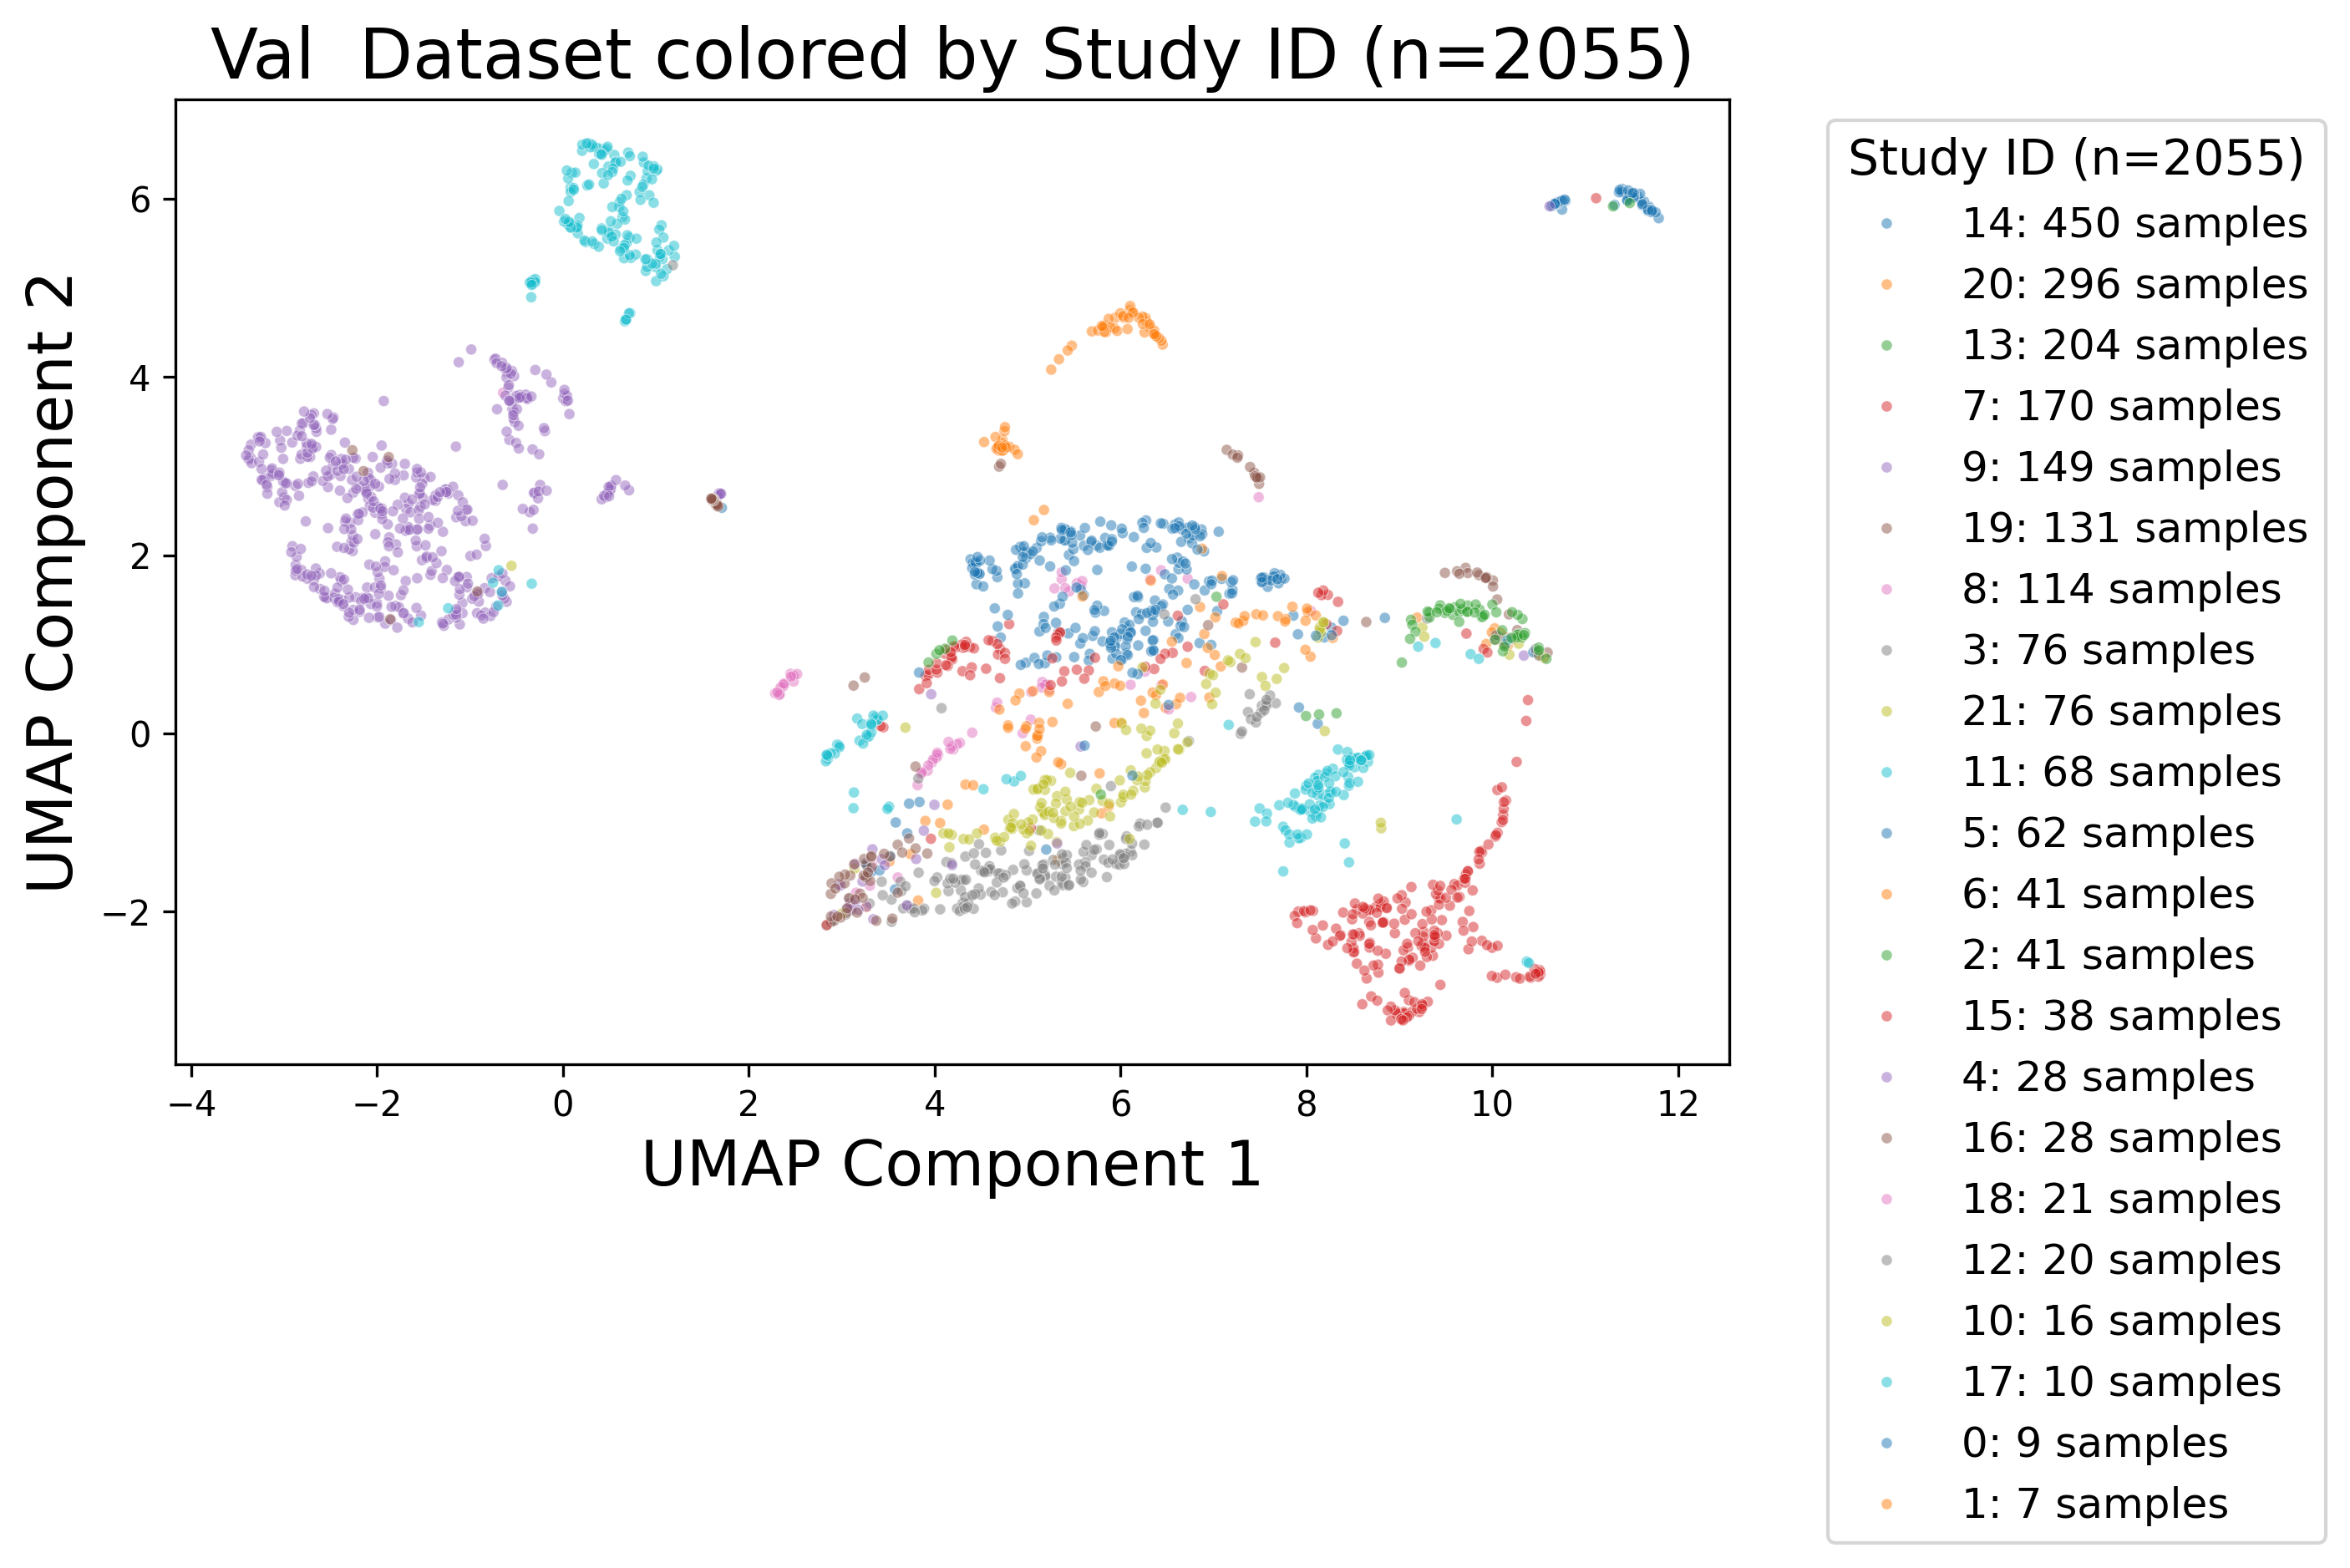

In [27]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(8,5), dpi=300)  # Adjusted figsize for square subplots
filter_and_plot_cat(Z_reduced_val_adv, y_data_val, 'Val  Dataset', task, axs)
# axs.set_xlim(10, None)  # y-axis limits, lower bound of -4, no upper bound
# axs.set_ylim(6, None) 

fig.savefig(f'{model_path}/Z_val_avg_{task_name}_UMAP.png')
#plt.tight_layout()

### Test Samples

In [28]:
#reducer = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.1, n_epochs=1000)
reducer = umap.UMAP(n_components=2)
Z_reduced_test_adv = reducer.fit_transform(Z_test_adv)
Z_reduced_test_adv.shape

(1028, 2)

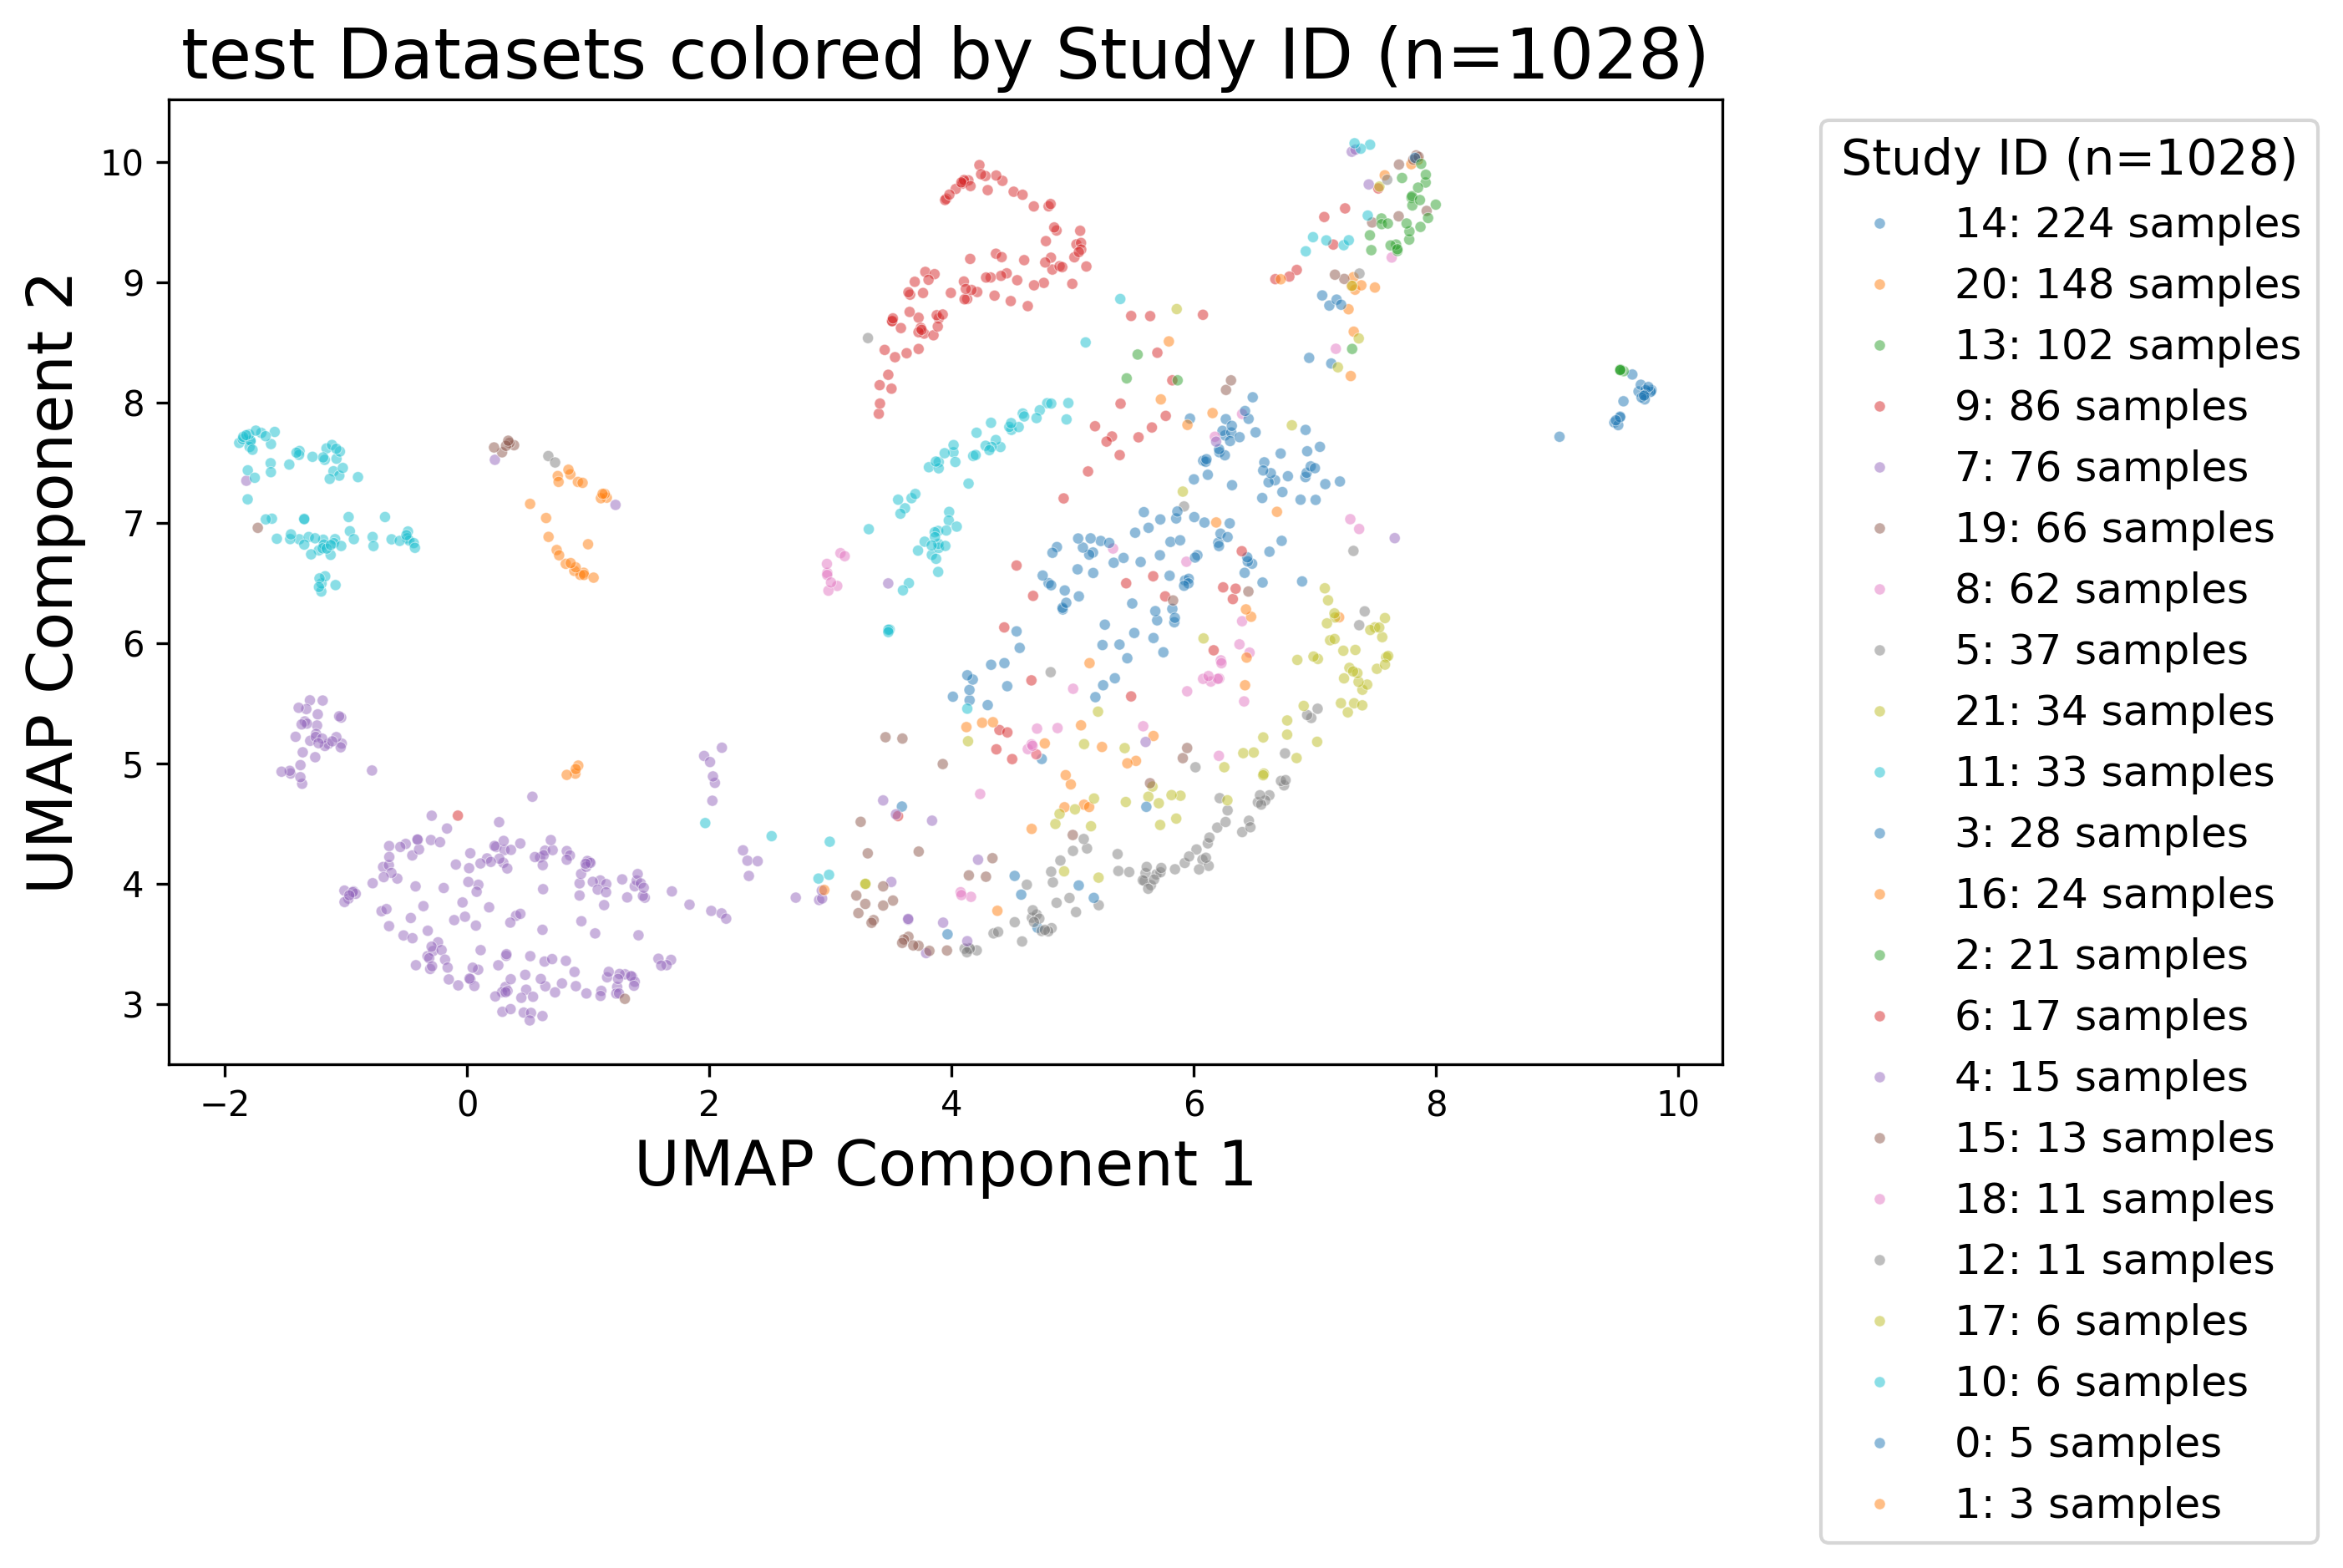

In [29]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(8,5), dpi=300)  # Adjusted figsize for square subplots
filter_and_plot_cat(Z_reduced_test_adv, y_data_test, 'test Datasets', task, axs)
# axs.set_xlim(10, None)  # y-axis limits, lower bound of -4, no upper bound
# axs.set_ylim(6, None) 

fig.savefig(f'{model_path}/Z_test_avg_{task_name}_UMAP.png')
#plt.tight_layout()

### All Samples

In [30]:
reducer = umap.UMAP(n_components=2, n_neighbors=100, min_dist=0.75, n_epochs=1000)
#reducer = umap.UMAP(n_components=2)
Z_reduced_all_adv = reducer.fit_transform(Z_all_adv)
Z_reduced_all_adv.shape

(20548, 2)

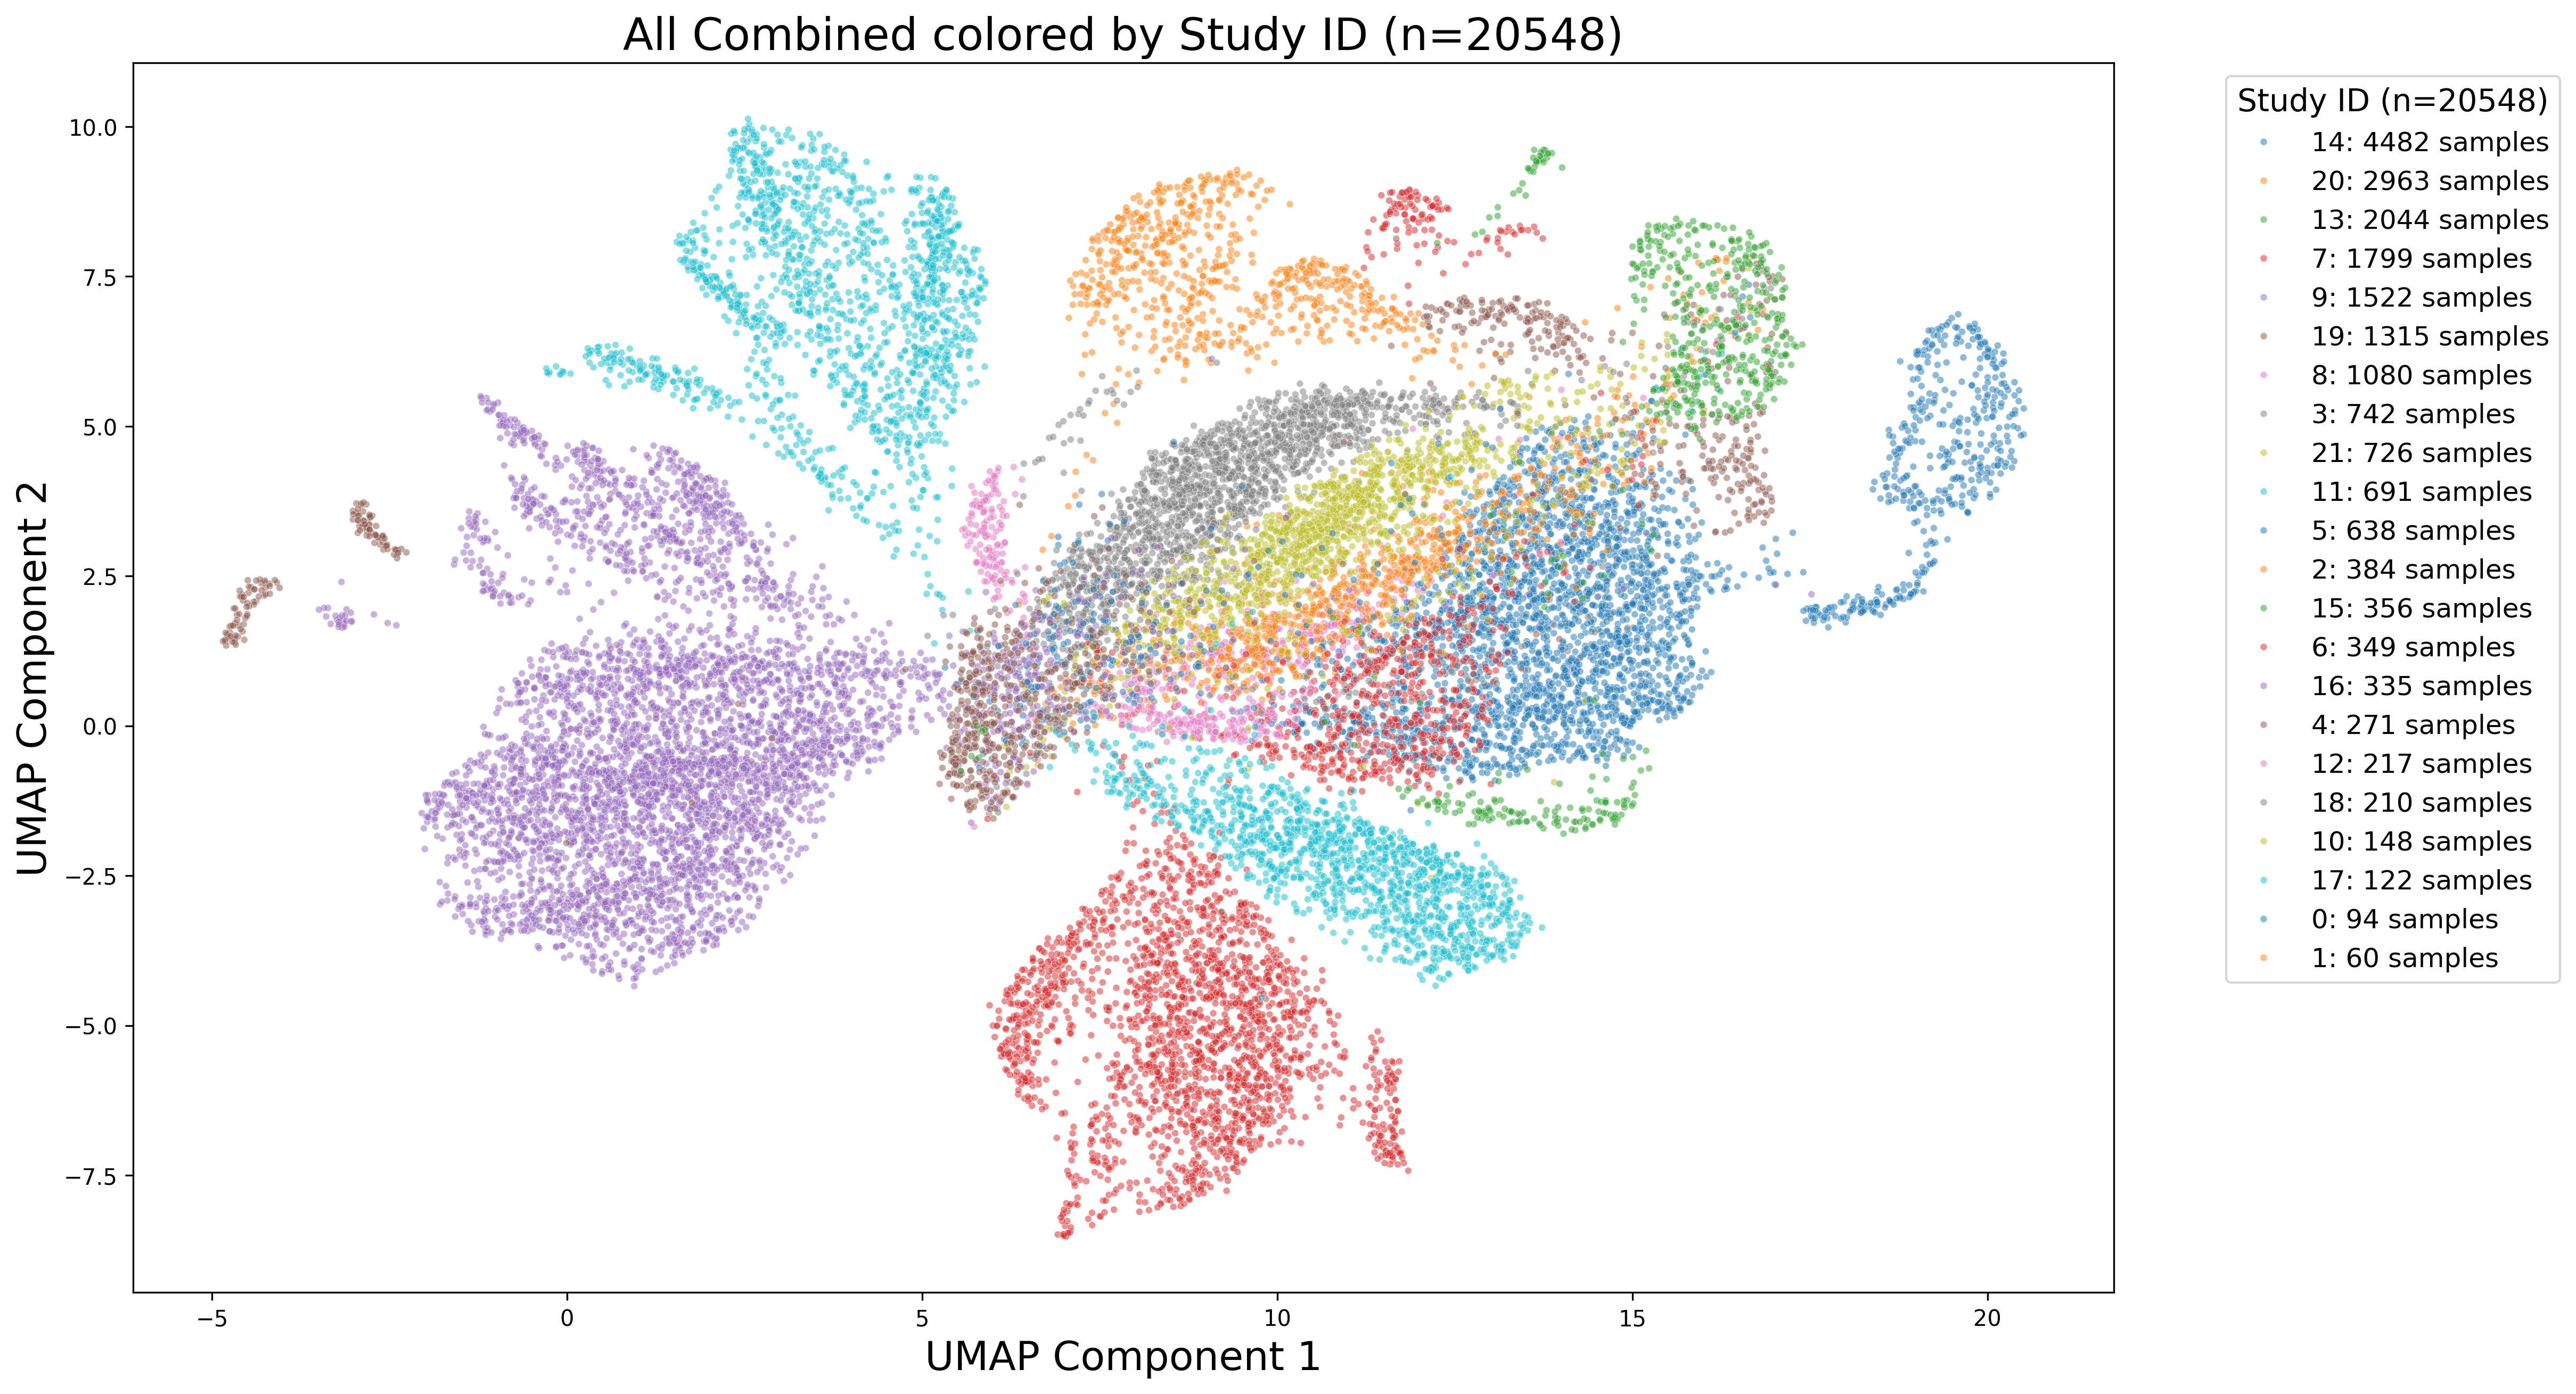

In [31]:
import matplotlib.pyplot as plt
task='Study ID'
fig, axs = plt.subplots(figsize=(16,10), dpi=300)  # Adjusted figsize for square subplots
filter_and_plot_cat(Z_reduced_all_adv, y_data_all, 'All Combined', task, axs)
# axs.set_xlim(10, None)  # y-axis limits, lower bound of -4, no upper bound
# axs.set_ylim(6, None) 
task_name=task.replace(' ','_')
fig.savefig(f'{model_path}/Z_all_avg_{task_name}_UMAP.png')
#plt.tight_layout()